# Machine Learning for NLP

Now, we will explore how to use Machine Learning for NLP such as Topic Modeling.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("./../assets/data_large_clean.csv", index_col = 0)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(38912, 7)


,city,searched_zipcode,url,region,type of employment,content,clean_content
0,ElPaso,79936,https://elpaso.craigslist.org/res/d/profession...,elpaso,professional-talented-and-energetic,Reliable well organized professional with stro...,reliable well organized professional with stro...
1,ElPaso,79936,https://elpaso.craigslist.org/res/d/outbound-r...,elpaso,outbound-retention-specialist,"ASIDE FROM WORD OF MOUTH OR FACE TO FACE , COL...","aside from word of mouth or face to face , col..."
2,ElPaso,79936,https://elpaso.craigslist.org/res/d/looking-fo...,elpaso,looking-for-new-career-move-you-need,I DO BEST RESUMES IN TOWN.\n\nI AM TECHNICAL W...,i do best resumes in town.. i am technical wri...
3,ElPaso,79936,https://elpaso.craigslist.org/res/d/im-looking...,elpaso,im-looking-for-work,"hola busco trabajo vivo para el east,me urge u...","hola busco trabajo vivo para el east,me urge u..."
4,ElPaso,79936,https://elpaso.craigslist.org/res/d/yard-work/...,elpaso,yard-work,Contact me to clean your yard today! Front and...,contact me to clean your yard today! front and...


Remove unneccesary rows and duplicate rows.

In [3]:
df.drop(columns = ['searched_zipcode', 'url', 'region', 'type of employment', 'content'], inplace = True)
df.drop_duplicates(subset = 'clean_content', keep = 'first', inplace = True)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(12908, 2)


,city,clean_content
0,ElPaso,reliable well organized professional with stro...
1,ElPaso,"aside from word of mouth or face to face , col..."
2,ElPaso,i do best resumes in town.. i am technical wri...
3,ElPaso,"hola busco trabajo vivo para el east,me urge u..."
4,ElPaso,contact me to clean your yard today! front and...


## Topic Modelling
### Latent Dirichlet Allocation (LDA)
The idea is each word contributes to the likelihood of a document to be of a certain topic.

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
count = CountVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        max_features = 5000)

lda = LatentDirichletAllocation(n_components = 20,
                                learning_method = 'online',
                                random_state = 20,
                                verbose = 1,
                                n_jobs = -1)

In [6]:
features = count.fit_transform(df['clean_content'])

In [7]:
features = lda.fit_transform(features)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [8]:
text_2_idx = count.vocabulary_
idx_2_text = {idx:text for text, idx in text_2_idx.items()}

In [43]:
topic_keyword_dict = {}
for topic_idx in range(20):
    topic_keywords = []
    for word_idx in lda.components_[topic_idx].argsort()[::-1][:10]:
        topic_keywords.append(idx_2_text[word_idx])
    print(f"Topic {topic_idx}:\n\t{' '.join(topic_keywords)}")
    topic_keyword_dict[topic_idx] = ' '.join(topic_keywords)

Topic 0:
	food events event chef cook hear bar children prep private
Topic 1:
	care home experience years caregiver references available patient patients personal
Topic 2:
	management reports office medical software manager insurance procedures new billing
Topic 3:
	las vegas contact en info safety la el mi trabajo
Topic 4:
	driver truck driving license class experience clean cdl record trucks
Topic 5:
	work help business need contact free services email years professional
Topic 6:
	experience skills assistant work office years service position customer time
Topic 7:
	design com designer graphic production video www https photography los
Topic 8:
	work experience years construction contact repair info tools electrical looking
Topic 9:
	school student college students english teaching teacher learning high language
Topic 10:
	work contact need looking cleaning info job help clean jobs
Topic 11:
	systems il software support engineering engineer network technical test hardware
Topic 12:
	

We can then infer topics from the words that contribute the most to each topic such as:

- Topic 0  : Cooking
- Topic 1  : Caregiver
- Topic 2  : Management
- Topic 3  : Jobs in Las Vegas
- Topic 4  : Truck driving
- etc...

In [10]:
df['topic'] = [row.argsort()[-1] for row in features]

In [11]:
df.loc[df['topic'] == 19].head()

,city,clean_content,topic
7,ElPaso,looking for a new job and no respond from the ...,19
11,ElPaso,"hello my name is jaqueline, i’m 18 years old, ...",19
29,ElPaso,new in town hoping to start something good her...,19
30,ElPaso,im looking for someone that needs help with ho...,19
40,ElPaso,"hello, my name is alex, my legal name is summe...",19


### TSNE

In [12]:
from sklearn.manifold import TSNE

In [24]:
new_york_data = df.loc[df['city'] == 'NewYork'].drop_duplicates(subset = 'clean_content',
                                                               keep = 'first')

In [75]:
count = CountVectorizer(analyzer = 'word',
                        stop_words = 'english')

tfidf = TfidfVectorizer(analyzer = 'word',
                        stop_words = 'english')

tsne = TSNE(n_components = 2,
            metric = 'euclidean',
            verbose = 1,
            random_state = 42)

In [76]:
tsne_feature = tfidf.fit_transform(new_york_data['clean_content'])
tsne_feature = tsne.fit_transform(tsne_feature.todense())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2745 samples in 1.206s...
[t-SNE] Computed neighbors for 2745 samples in 148.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2745
[t-SNE] Computed conditional probabilities for sample 2000 / 2745
[t-SNE] Computed conditional probabilities for sample 2745 / 2745
[t-SNE] Mean sigma: 0.263922
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.533836
[t-SNE] KL divergence after 1000 iterations: 2.296160


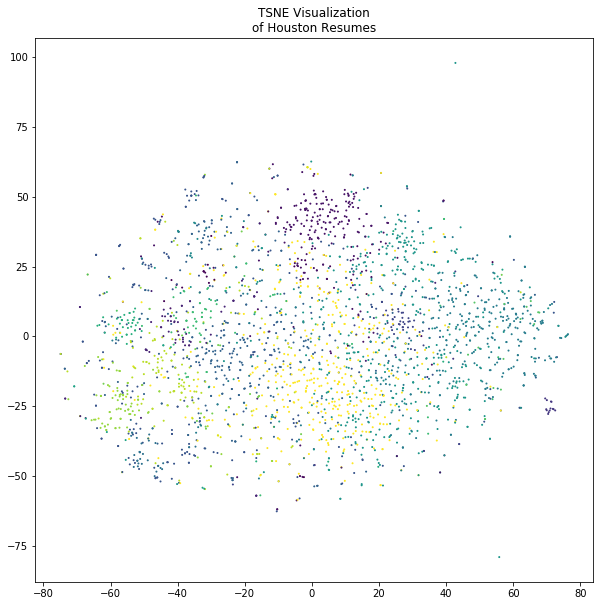

In [77]:
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = 1, c = new_york_data['topic'])
plt.title("TSNE Visualization\nof Houston Resumes")
plt.show()

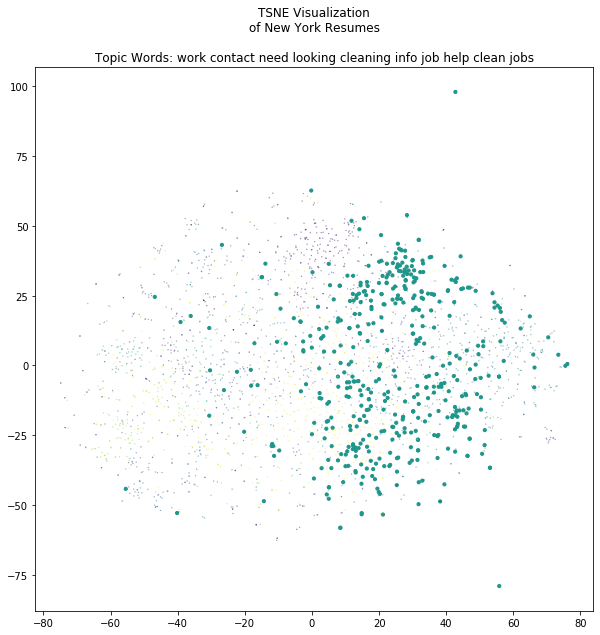

In [78]:
highlight_topic = 10
sizes = [10 if a == highlight_topic else 0.05 for a in new_york_data['topic']]
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = sizes, c = new_york_data['topic'])
plt.title(f"TSNE Visualization\nof New York Resumes\n\nTopic Words: {topic_keyword_dict[highlight_topic]}")
plt.show()